# 1. Install Dependencies and Setup

In [1]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [5]:
!pip list

Package                       Version
----------------------------- ---------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array-record                  0.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         23.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
build                         0.10.0
CacheControl                  0.12.11
ca

In [6]:
#NEW
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd "/content/drive/MyDrive/Colab Notebooks/multiple_houses"

/content/drive/MyDrive/Colab Notebooks/multiple_houses


In [8]:
import tensorflow as tf
import os

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [11]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [12]:
data_dir = os.getcwd()+'/data'

In [13]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [14]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [15]:
img.shape

(640, 640, 3)

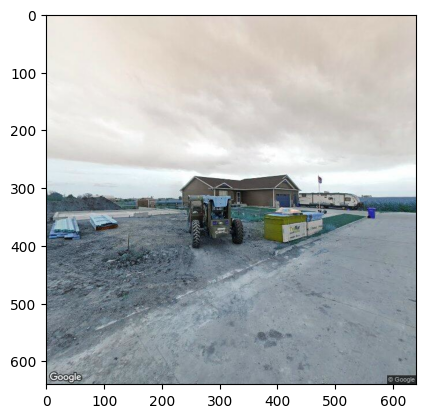

In [16]:
plt.imshow(img)

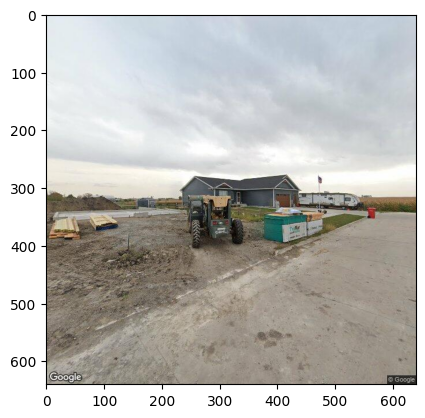

In [17]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. Load Data

In [18]:
import numpy as np
from matplotlib import pyplot as plt

In [19]:
# classifies the input images as 1 or 0 so that when you train the image the model knows which classification each image is given
data = tf.keras.utils.image_dataset_from_directory('data')

Found 507 files belonging to 3 classes.


In [20]:
data_iterator = data.as_numpy_iterator()

In [21]:
#len(list(data_iterator))


In [22]:
batch = data_iterator.next()

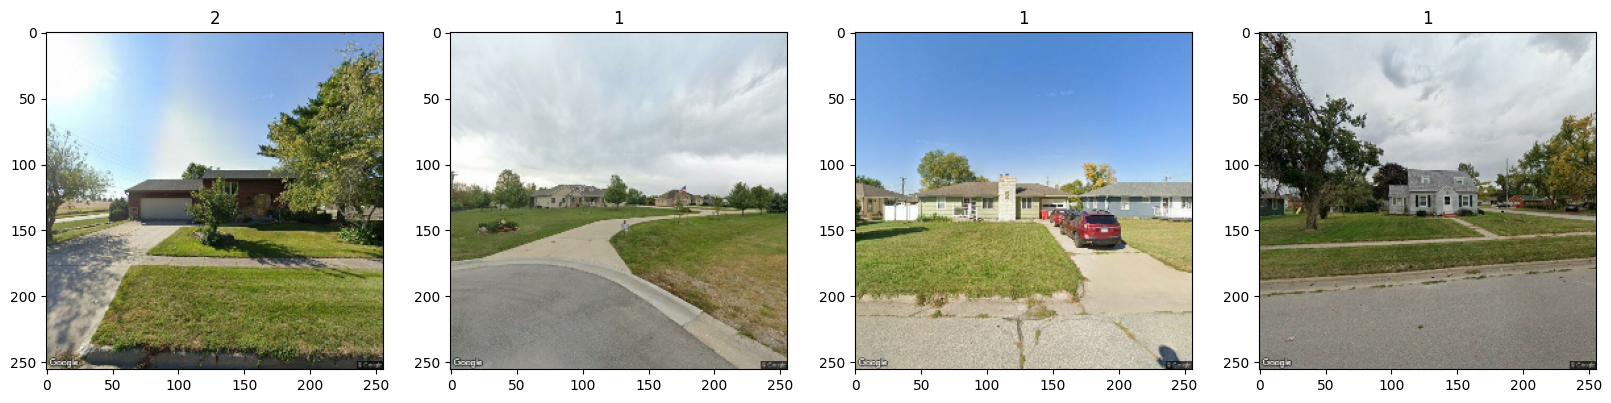

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
#1 is for multiple houses, 2 is one house

# 4. Scale Data

In [24]:
data = data.map(lambda x,y: (x/255, y))

In [25]:
data.as_numpy_iterator().next()

(array([[[[0.35049018, 0.4014706 , 0.0870098 ],
          [0.40784314, 0.4629902 , 0.12671569],
          [0.41813725, 0.4776961 , 0.10441177],
          ...,
          [0.43529412, 0.60784316, 0.8627451 ],
          [0.43823528, 0.6107843 , 0.8656863 ],
          [0.44240198, 0.61495095, 0.86985296]],
 
         [[0.34142157, 0.37769607, 0.10465686],
          [0.27965686, 0.31985295, 0.03308824],
          [0.4125    , 0.45637256, 0.13382353],
          ...,
          [0.4370098 , 0.6095588 , 0.86446077],
          [0.44240198, 0.61495095, 0.86985296],
          [0.44411764, 0.6166667 , 0.8715686 ]],
 
         [[0.49191177, 0.5132353 , 0.25196078],
          [0.3990196 , 0.4237745 , 0.14117648],
          [0.3514706 , 0.37916666, 0.07990196],
          ...,
          [0.44240198, 0.61495095, 0.86985296],
          [0.44534314, 0.61789215, 0.8727941 ],
          [0.44705883, 0.61960787, 0.8745098 ]],
 
         ...,
 
         [[0.8490196 , 0.8039216 , 0.7345588 ],
          [0.82573

# 5. Split Data

In [26]:
len(data)

16

In [27]:
#70% testing 20% validation 10% testing
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [28]:
train_size+val_size+test_size

17

In [29]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [30]:
print(len(test))

print(len(val))

len(train)

1
4


11

# 6. Build Deep Learning Model

In [31]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [33]:
model = Sequential()

In [34]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#activation = 'softmax' for dense layers greater than 1

In [35]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [37]:
logdir='logs'

In [38]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
#NEW
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
hist = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[tensorboard_callback])

Epoch 1/20
11/11 [==============================] - 17s 252ms/step - loss: -47.0238 - accuracy: 0.8153 - val_loss: -191.3794 - val_accuracy: 0.8203
Epoch 2/20
11/11 [==============================] - 0s 44ms/step - loss: -906.1005 - accuracy: 0.8153 - val_loss: -2671.3916 - val_accuracy: 0.8203
Epoch 3/20
11/11 [==============================] - 0s 40ms/step - loss: -8146.4771 - accuracy: 0.8153 - val_loss: -18802.6328 - val_accuracy: 0.8203
Epoch 4/20
11/11 [==============================] - 0s 38ms/step - loss: -45870.7969 - accuracy: 0.8153 - val_loss: -93845.7812 - val_accuracy: 0.8203
Epoch 5/20
11/11 [==============================] - 0s 39ms/step - loss: -199270.8906 - accuracy: 0.8153 - val_loss: -357019.6250 - val_accuracy: 0.8203
Epoch 6/20
11/11 [==============================] - 0s 39ms/step - loss: -654665.9375 - accuracy: 0.8153 - val_loss: -1101913.5000 - val_accuracy: 0.8203
Epoch 7/20
11/11 [==============================] - 0s 39ms/step - loss: -1945849.5000 - accurac

# 8. Plot Performance

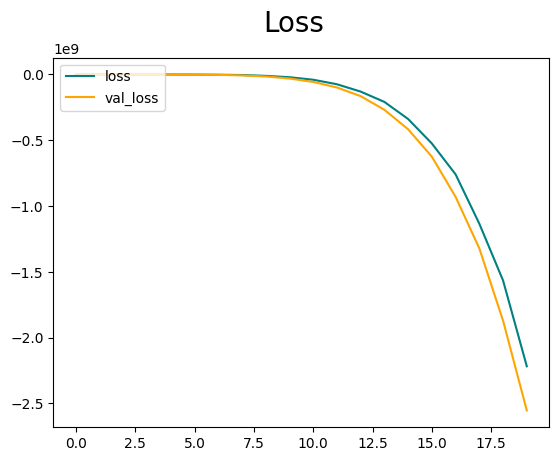

In [41]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

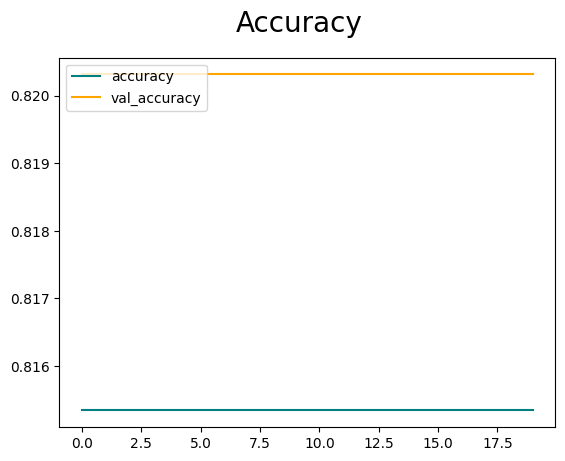

In [42]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [43]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [44]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [45]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    print(yhat)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 401ms/step
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [46]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.7407407, shape=(), dtype=float32)


In [47]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:0.7407407164573669


# 10. Test

In [48]:
import cv2

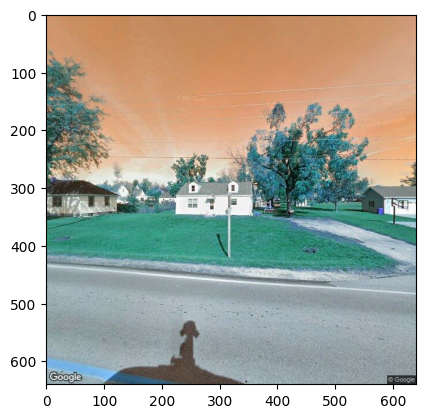

In [49]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/multiple_houses/data/multiple houses/G_S_105 E 6TH AVE_.png')
#img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/multiple_houses/data/multiple houses/G_S_300 10TH AVE_.png')
#img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/multiple_houses/data/one house/G_S_701 PARK CIR_.png')
plt.imshow(img)
plt.show()

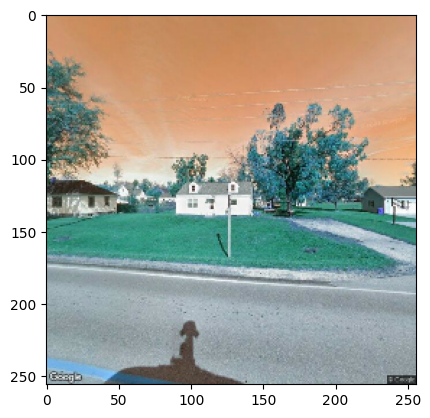

In [50]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [51]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 100ms/step


In [52]:
yhat

array([[1.]], dtype=float32)

In [53]:
if yhat > 0.5:
    print(f'Multiple houses')
else:
    print(f'One house')

Multiple houses


# 11. Save the Model

In [54]:
from tensorflow.keras.models import load_model

In [55]:
model.save(os.path.join('models','house_present_classifier.h5'))

In [56]:
new_model = load_model(os.path.join('models', 'house_present_classifier.h5'))

In [57]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 79ms/step


array([[1.]], dtype=float32)

In [58]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0